In [77]:
import librosa
import numpy as np
import IPython.display as ipd
# ipd.Audio('audio/conga_groove.wav') # load a local WAV file
# ipd.Audio(x, rate=sr) # load a NumPy array
import matplotlib
import matplotlib.pylab as plt
from matplotlib import cm
import torch
import os, glob

from src.utils.hparams import HParam
from src.models.GPV import GPV
from src.models.MISO32v2 import MISO32v2

## Config

In [495]:
sr      = 16000
n_fft   = 512
n_shift = 128
n_hfft = n_fft/2+1
n_overlap = n_fft - n_shift

time_shift = (1/sr)*n_shift

n_mels  = 40
target='GPV_2'

n_mels  = 64
target='GPV_1'

n_mels  = 32
target='miso_3'

#n_mels  = 32
#target='miso_1_ver2'

mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

root = '/home/data2/kbh/AVTR/extract/'
list_target = [x for x in glob.glob(os.path.join(root,'wav','*.wav'))]

path_config='./config/'+target+'.yaml'

## Load

In [496]:
idx_target = 5
path_wav = list_target[idx_target]
print(path_wav)
id_target = path_wav.split('/')[-1].split('.')[0]
path_label = os.path.join(root,'label',id_target+'.npy')

/home/data2/kbh/AVTR/extract/wav/266.wav


In [497]:
raw, _ = librosa.load(path_wav,sr=sr)
npy_label_true = np.load(path_label)

print(np.shape(raw))
print(npy_label_true)

(2766848,)
[[  9.131  11.172]
 [ 11.926  13.784]
 [ 14.386  15.296]
 [ 17.591  19.03 ]
 [ 20.622  21.057]
 [ 21.291  26.284]
 [ 29.567  31.054]
 [ 31.387  32.845]
 [ 33.976  39.667]
 [ 40.98   43.868]
 [ 45.206  47.296]
 [ 49.152  49.906]
 [ 50.59   56.986]
 [ 57.644  60.48 ]
 [ 62.166  62.618]
 [ 63.691  65.19 ]
 [ 66.081  66.6  ]
 [ 66.742  70.326]
 [ 71.93   73.879]
 [ 73.993  74.544]
 [ 74.574  76.58 ]
 [ 84.394  88.335]
 [ 88.351  96.293]
 [112.859 114.178]
 [114.258 115.633]
 [119.464 121.989]
 [127.454 128.45 ]
 [131.134 132.413]
 [160.931 169.931]
 [170.175 172.648]]


## Sample

In [498]:
sec_s = 0
sec_e = 20

# sample
spec = librosa.stft(raw,window='hann', n_fft=n_fft, hop_length=n_shift , win_length=None ,center=True)

label_true = np.zeros(np.shape(spec)[1])

for i in npy_label_true:
    #print(i)
    #print( int(i[0]*sr/n_shift))
    #print( int(i[1]*sr/n_shift))
    label_true[ int( i[0]/time_shift):int(i[1]/time_shift)] = 1
#print(np.shape(spec))
#print(np.shape(label_true))

spec = spec[:,int(sec_s/time_shift):int(sec_e/time_shift)]
label_true = label_true[int(sec_s/time_shift):int(sec_e/time_shift)]

print(np.shape(spec))

(257, 2500)


## VAD label

In [499]:
hp = HParam(path_config)

mel = np.matmul(mel_basis,np.abs(spec))
pt = torch.from_numpy(mel)
pt = pt.float()

if hp.model.type == "GPV":
    model = GPV(hp,inputdim=hp.model.n_mels)
elif hp.model.type == 'MISO32v2':
    num_bottleneck = 5
    en_bottleneck_channels = [1,24,32,64,128,384,64] # 16: 2*Ch 
    Ch = 1  # number of mic
    norm_type = 'IN'  #Instance Norm
    model = MISO32v2(num_bottleneck,en_bottleneck_channels,Ch,norm_type)
model.load_state_dict(torch.load('/home/nas/user/kbh/VADK/chkpt/'+target+'/bestmodel.pt'))
model.eval()
with torch.no_grad():
    pt = torch.unsqueeze(pt,0)
    label_vad = torch.squeeze(model(pt))
    
print(label_vad.shape)

label_vad = label_vad.detach().numpy()


torch.Size([2500])


## miso_3 

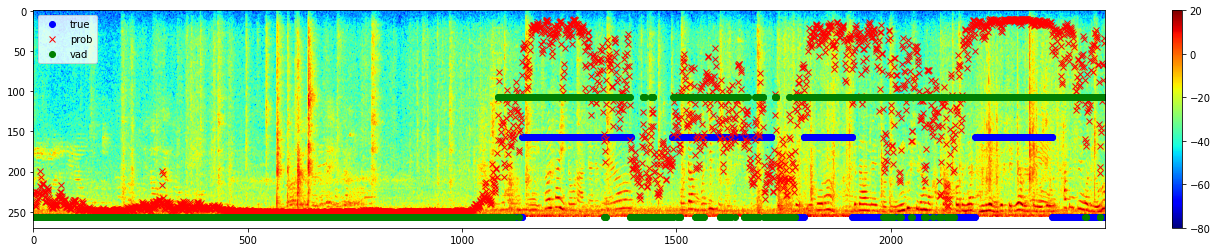

In [506]:
# dB scale

ipd.display(ipd.Markdown('## '+target + ' '))
plt.figure(figsize=(24, 4))
eps = 1e-13
tmp =(np.abs(spec[:,:]))
tmp = np.clip(tmp,a_min=eps,a_max=None)
tmp = 20*np.log10(tmp)
tmp = tmp[::-1,:]

im = plt.imshow(tmp, cmap=cm.jet, aspect='auto')
plt.colorbar(im)
plt.clim(-80,20)

plt.plot(range(len(label_true)),n_hfft -( label_true)*100,'bo',label='true')

plot_prob = 250 -label_vad * 240
plt.plot(range(len(label_true)),plot_prob,'rx',label='prob')

plot_vad = (label_vad>0.4)
plt.plot(range(len(label_true)),n_hfft -( plot_vad)*150,'go',label='vad')

plt.legend()
plt.show()



In [501]:
raw_sample = raw[sec_s*sr :sec_e*sr]
ipd.display(ipd.Markdown('## raw'))
ipd.display(ipd.Audio(raw_sample, rate=sr))
print(np.shape(raw_sample))










real = []
for i in range(len(label_true)):
    if label_true[i] == 1 : 
        real.extend(raw_sample[(i-1)*n_shift:(i)*n_shift])
    
print(np.shape(real))
ipd.display(ipd.Markdown('## true'))
ipd.display(ipd.Audio(real, rate=sr))


output = []
for i in range(len(label_vad)):
    if label_vad[i] > 0.1 : 
        output.extend(raw_sample[(i-1)*n_shift:(i)*n_shift])
    
print(np.shape(output))
ipd.display(ipd.Markdown('## output > 0.1'))
ipd.display(ipd.Audio(output, rate=sr))

output = []
for i in range(len(label_vad)):
    if label_vad[i] > 0.4 : 
        output.extend(raw_sample[(i-1)*n_shift:(i)*n_shift])
    
print(np.shape(output))
ipd.display(ipd.Markdown('## output > 0.4'))
ipd.display(ipd.Audio(output, rate=sr))

## raw

(320000,)
(99968,)


## true

(184576,)


## output > 0.1

(143360,)


## output > 0.4